I do Fisher exact tests on junctions we already know are alternatively spliced from short reads just to see what concordance looks like.

A few genes have p-values that aren't 1, however none have a value below 0.05. The x-axis is arbitrarily indexed.

In [13]:
setwd('~/bme')
wt_counts = read.table('junction_counts_long.wt.6.txt')
mt_counts = read.table('junction_counts_long.6.txt')
wt_counts$V1 = as.character(wt_counts$V1)
mt_counts$V1 = as.character(mt_counts$V1)
head(cbind(wt_counts, mt_counts))

V1,V2,V3,V4,V5,V1,V2,V3,V4,V5
PCK2,24099721,24099994,0,1,PCK2,24099721,24099994,2,1
PCK2,24099721,24102752,0,1,PCK2,24099721,24102752,1,1
"GOLGA6L5,RP11-182J1.12",84513303,84513966,0,1,"GOLGA6L5,RP11-182J1.12",84513303,84513966,0,1
"GOLGA6L5,RP11-182J1.12",84513331,84513966,0,1,"GOLGA6L5,RP11-182J1.12",84513331,84513966,0,1
DDHD2,38237628,38238106,0,1,DDHD2,38237628,38238106,0,1
DDHD2,38237628,38238088,1,1,DDHD2,38237628,38238088,0,1


In [14]:
current_gene = ''
genes = c()
pvals = c()  # for collecting results
sigrows = c()
for (row in 1:(nrow(wt_counts))+1) {  # looping through table and pulling out rows with shared gene names to do fisher tests on
    if (row == nrow(wt_counts)+1 || wt_counts[row, 1] != current_gene | nchar(current_gene)==0) {
        if (nchar(current_gene) > 0 && (nrow(wtinfo) > 1)) {
            for (i in 1:(nrow(wtinfo))) {
                for (j in i:nrow(wtinfo)) {
                    ctable = matrix(unlist(c(wtinfo[c(i,j),4], mtinfo[c(i,j),4])), nrow=2)
                    if (sum(ctable) != 0 && wtinfo[i,2] == wtinfo[j,2] | wtinfo[i,3] == wtinfo[j,3]) {  # extra check for genes with multiple alt splice junctions
                        if (fisher.test(ctable)$p.value < 0.6) {
                            sigrows = c(sigrows, row-nrow(wtinfo)+i-1, row-nrow(wtinfo)+j-1)
                        }
                        pvals = c(pvals, fisher.test(ctable)$p.value)
                        genes = c(genes, current_gene)
                    }
                }
                
            }
        }
        current_gene = wt_counts[row, 1]
        wtinfo = wt_counts[row,]
        mtinfo = mt_counts[row,]
    } else {
        wtinfo = rbind(wtinfo, wt_counts[row,])
        mtinfo = rbind(mtinfo, mt_counts[row,])
    }
}

In [120]:
sigrows = sort(unique(sigrows))
head(cbind(wt_counts[sigrows,], mt_counts[sigrows,]))

,V1,V2,V3,V4,V5,V1,V2,V3,V4,V5
17,ERGIC3,35556272,35556990,0,1,ERGIC3,35556272,35556990,0,1
18,ERGIC3,35556749,35556954,0,1,ERGIC3,35556749,35556954,0,1
19,ERGIC3,35556272,35556954,0,1,ERGIC3,35556272,35556954,6,1
31,FKBP3,45130801,45134348,2,1,FKBP3,45130801,45134348,10,1
32,B3GAT3,62620672,62621865,0,1,B3GAT3,62620672,62621865,4,1
40,SRSF11,70228556,70232267,2,1,SRSF11,70228556,70232267,12,1


[1] -3.321928

[1] -2.321928

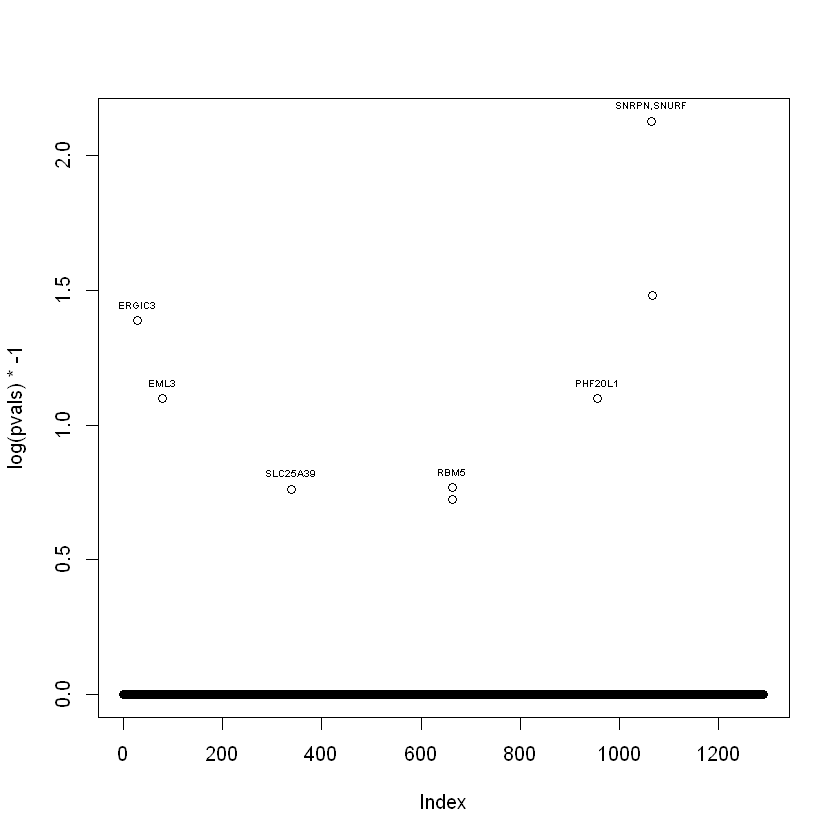

In [145]:
plot(log(pvals)*-1)
df = data.frame(g=genes, p=pvals)
df$pos = 1:nrow(df)
df = df[df$p < 0.6,]
newdf = df[1,]
for (row in 2:nrow(df)) {
    if (!df[row,1] %in% newdf[,1]) {
        newdf = rbind(newdf, df[row,])
    } else if (any((df[row,2]+.01) <= newdf[newdf$g == df[row,1],2])) {
#         newdf[newdf$g == df[row,1],2] = df[row,2]
        newdf = rbind(newdf, df[row,])
    }
}
text(newdf$pos, log(newdf$p)*-1+.06, labels=newdf$g, cex=0.5)  # names above points
abline(h=log2(0.05))  # can't see
log2(0.1)
log2(0.2)

I use Jeltje's bedfile of corrected junctions and the junction counts in there and do lots of fisher tests. I'm looking specifically at 3' SS alterations, so I compare counts for different 3' SSs in the mutant and wildtype for junctions with the same 5' SS. Jeltje mentioned that the strand doesn't carry meaning in her bedfile, so I repeat this analysis treating "3'" as 5' SSs.

In [21]:
setwd('~/bme')
mtalt = read.table('altsplicejunction_counts.txt')
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'counts')
wtalt = read.table('altsplicejunction_counts.wt.txt')
together = mtalt
together$wt = wtalt$V4[match(mtalt$mt5, wtalt$V2)]
together$wtchrom = wtalt$V1[match(mtalt$mt5, wtalt$V2)]  # sanity check
together$mtchrom = as.character(together$mtchrom)
together$wtchrom = as.character(together$wtchrom)
together = together[!is.na(together$wt) & together$wtchrom == together$mtchrom,]
head(together)  # data frame containing junction counts for both mutant and wildtype

,mtchrom,mt5,mt3,counts,wt,wtchrom
20,chrY,1389707,1391934,1,10,chrY
21,chrY,1389707,1391947,1,10,chrY
22,chrY,1389707,1391918,54,10,chrY
78,chrX,154399376,154399527,1,1,chrX
79,chrX,154399376,154399520,5,1,chrX
80,chrX,154399376,154399506,101,1,chrX


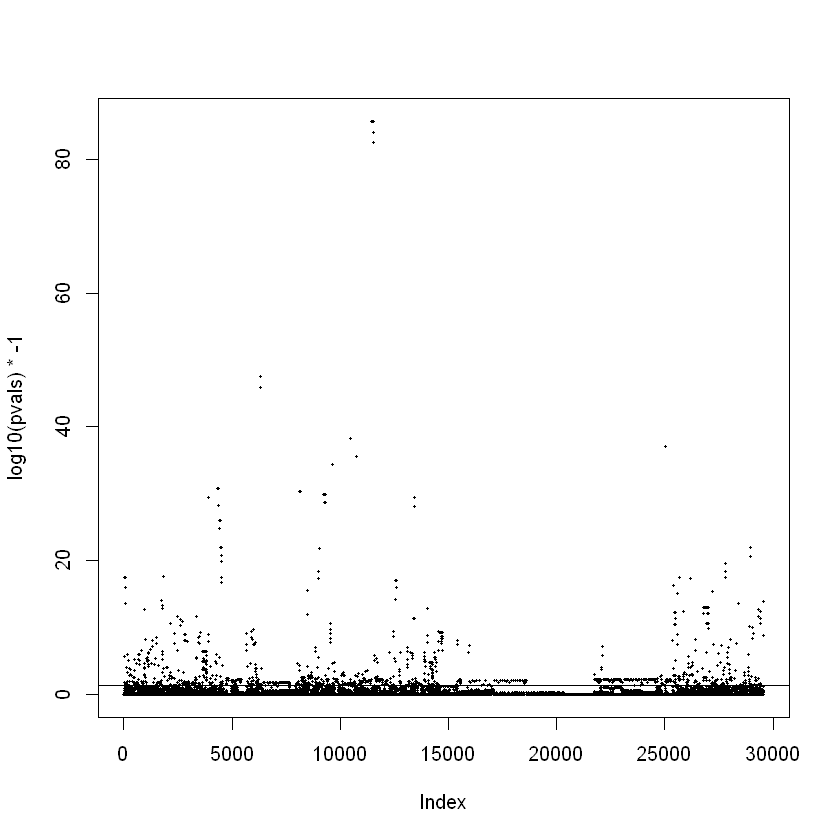

In [15]:
current_gene = paste0(together[1,1],':',together[1,2])
info = together[1,]
genes = c()
pvals = c()
for (row in 2:nrow(together)) {
    nameinit = paste0(together[row,1],':',together[row, 2])
    if (nameinit != current_gene) {
        for (i in 1:(nrow(info)-1)) {
            for (j in (i+1):nrow(info)) {
                ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                if (sum(ctable) != 0) {
                    pvals = c(pvals, fisher.test(ctable)$p.value)
                    genes = c(genes, current_gene)
                }
            }    
        }
        current_gene = nameinit
        info = together[row,]
    } else {
        info = rbind(info, together[row,])
    }
}
rgenes = genes[pvals < 0.2]
rpvals = pvals[pvals < 0.2]
plot(log10(pvals)*-1, pch=16, cex=0.3)
# text(1:length(rpvals), log10(rpvals)*-1+.03, labels=rgenes, cex=0.5)  # names above points
abline(h=log10(0.05)*-1)


Above: every point is the result of one fisher test between alternative junction events. These are only considering 3' splice site alterations, so if you look at the the mutant 5' position column (together$mt5), comparisons are done within a group of junctions sharing the same 5' end.

Below: Like the plot above, but instead anchoring at the 3' ends. Some of these junctions could still be technically 5' end-anchored since Jeltje said the counts were done without regard to strand and the bedfile of junctions does not have strand information.

,mtchrom,mt5,mt3,counts,wt,wtchrom
27843,chr9,18467,24870,1,1,chr9
27844,chr9,24618,24870,1,1,chr9
27845,chr9,18472,24870,3,1,chr9
2082,chr12,18459,26820,1,1,chr12
2083,chr12,18464,26820,3,1,chr12
2084,chr12,26568,26820,1,1,chr12


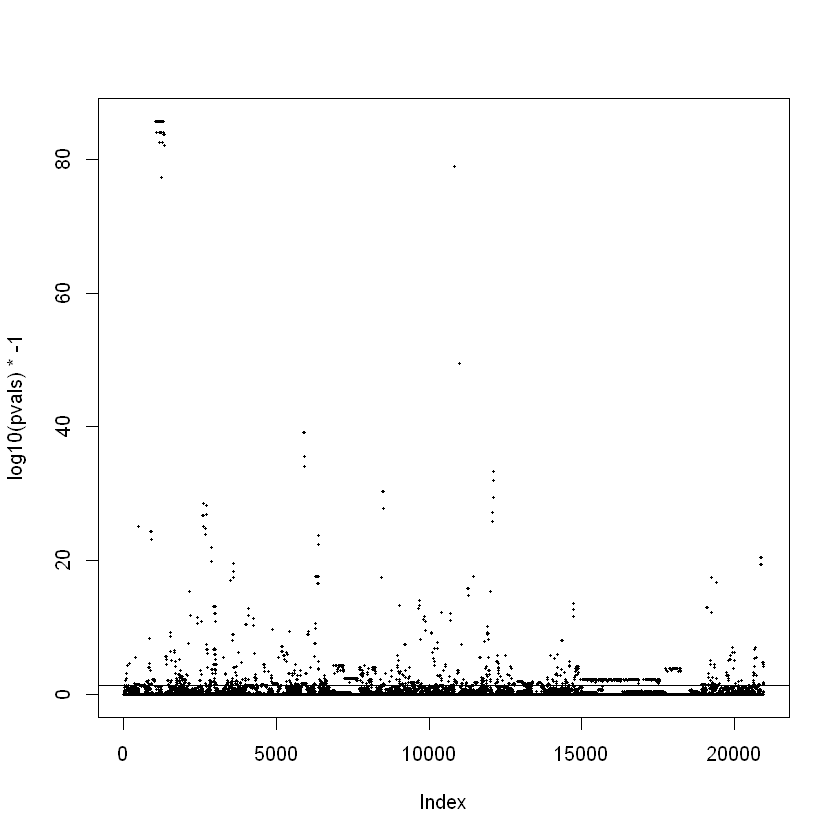

In [12]:
setwd('~/bme')
mtalt = read.table('altsplicejunction_counts.3.txt')   # anchored at the 3' site, aka the greater junction coordinate
colnames(mtalt) = c('mtchrom', 'mt5', 'mt3', 'counts')
wtalt = read.table('altsplicejunction_counts.3.wt.txt')
together = mtalt
together$wt = wtalt$V4[match(mtalt$mt3, wtalt$V3)]
together$wtchrom = wtalt$V1[match(mtalt$mt3, wtalt$V3)]  # sanity check
together$mtchrom = as.character(together$mtchrom)
together$wtchrom = as.character(together$wtchrom)
together = together[order(together$mt3),]
together = together[!is.na(together$wt) & together$wtchrom == together$mtchrom,]
head(together)  # data frame containing junction counts for both mutant and wildtype
current_gene = paste0(together[1,1],':',together[1,3])
info = together[1,]
genes = c()
pvals = c()
for (row in 2:nrow(together)) {
    nameinit = paste0(together[row,1],':',together[row, 3])
    if (nameinit != current_gene) {
        for (i in 1:(nrow(info)-1)) {
            for (j in (i+1):nrow(info)) {
                ctable = matrix(unlist(c(info[c(i,j),4], info[c(i,j),5])), nrow=2)
                if (sum(ctable) != 0) {
                    pvals = c(pvals, fisher.test(ctable)$p.value)
                    genes = c(genes, current_gene)
                }
            }    
        }
        current_gene = nameinit
        info = together[row,]
    } else {
        info = rbind(info, together[row,])
    }
}
rgenes = genes[pvals < 0.2]
rpvals = pvals[pvals < 0.2]
plot(log10(pvals)*-1, pch=16, cex=0.3)
# text(1:length(rpvals), log10(rpvals)*-1+.03, labels=rgenes, cex=0.5)  # names above points
abline(h=log10(0.05)*-1)
